In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

tfk = tf.keras
tfkl = tfk.layers
seed = 100
plt.style.use('ggplot')


## Load data
Load augmented data (sliding window). Data are already scaled with robust scaler.

In [2]:
X = np.load(f'/kaggle/input/augmented-challenge2/X_stride1.npy')
y = np.load(f'/kaggle/input/augmented-challenge2/y_stride1.npy')

X.shape

(87024, 36, 6)

## Compute weights for classes

In [3]:
counter = np.bincount(y)
frequencies = 1 / counter
weights = frequencies * (y.shape[0] / frequencies.shape[0])

w_s = {}
for i, w in enumerate(weights):
    w_s[i] = w
w_s

{0: 6.099243061396131,
 1: 1.6508081038015026,
 2: 0.7487867836861125,
 3: 0.5300782106571157,
 4: 3.300864815657715,
 5: 1.3250502466654486,
 6: 0.6455977922193537,
 7: 3.0053874844591792,
 8: 1.6924154025670946,
 9: 0.2595840641443247,
 10: 2.649616368286445,
 11: 4.026651860077735}

In [4]:
1 / frequencies

array([ 1189.,  4393.,  9685., 13681.,  2197.,  5473., 11233.,  2413.,
        4285., 27937.,  2737.,  1801.])

In [5]:
def evaluate_model(m, X_val, y_val):
    """
    This method computes the confusion matrix and recall, precision and f1-score for each class.
    :param m: model to evaluate.
    :param X_val: samples to use for the evaluation. X_val cannot be a tf.Dataset object.
    :param y_val: labels for each element of X_val. y_val cannot be a tf.Dataset object.
    :return pandas.DataFrame containing the confusion matrix and pandas.Dataframe whose rows 
    are recall,precision, f1-score and support, whereas columns are the labels.
    """
    y_pred = m.predict(X_val)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_val, axis=1)
    
    c_m = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize='true'))
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report = pd.DataFrame(report)
    report = report.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    
    return c_m, report

## Split data
loaded data use sliding window with stride 1, this means there are multiple samples sharing the same subset of timestamps. Samples sharing the same subset of timestamp must stay in the same set, otherwise we overfit the validation set and we vanish the help given by the validation set.


In [7]:
df = pd.DataFrame({'y': y})
starting_indexes = list(df.drop_duplicates(keep='first').index.values)
ending_indexes = starting_indexes[1:] + [df.index.values[-1] + 1]

X_train = None
X_val = None

y_train = None
y_val = None

train_percentage = 0.85


for label, starting_index, ending_index in zip(range(12), starting_indexes, ending_indexes):
    
    split_index = int(train_percentage * (ending_index - starting_index))
    split_index += starting_index
    assert split_index + 36 > starting_index
    if X_train is None:
        X_train = X[starting_index: split_index, :, :].copy()
        y_train = y[starting_index: split_index].copy()
        
        X_val = X[split_index + 36: ending_index, :, :].copy()
        y_val = y[split_index + 36: ending_index].copy()
    else:
        X_train = np.append(X_train, X[starting_index: split_index, :, :], axis=0)
        y_train = np.append(y_train, y[starting_index: split_index])
        
        X_val = np.append(X_val, X[split_index + 36: ending_index, :, :], axis=0)
        y_val = np.append(y_val, y[split_index + 36: ending_index])

        
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(73966, 36, 6) (12626, 36, 6) (73966, 12) (12626, 12)


## Analyze effect of GaussianDropout vs GaussianNoise.
Using Gaussian dropout, we multply the input by a Noise drawn from $\mathcal{N}(1, \sigma)$, where:

$\sigma = \sqrt{\frac{x}{1 - x}}$.

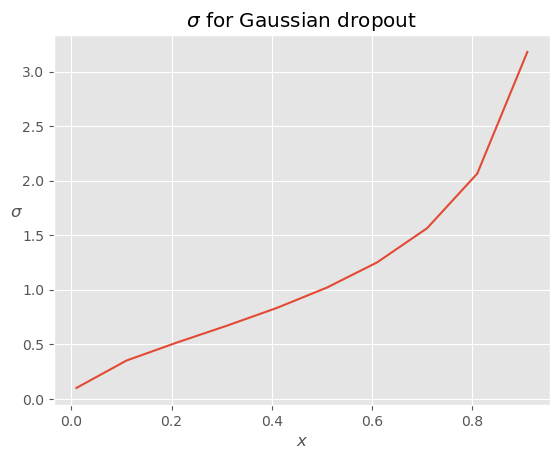

In [6]:
plt.title('$\sigma$ for Gaussian dropout')

plt.plot(np.arange(0.01,0.99, 0.1), np.sqrt(np.arange(0.01,0.99, 0.1) / (1 - np.arange(0.01,0.99, 0.1))))
plt.xlabel('$x$')
plt.ylabel('$\sigma$', rotation=0)
plt.show()

In [9]:
x = tfkl.GaussianDropout(0.4)

2022-12-13 17:32:36.701215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 17:32:36.791972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 17:32:36.792792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-13 17:32:36.794973: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

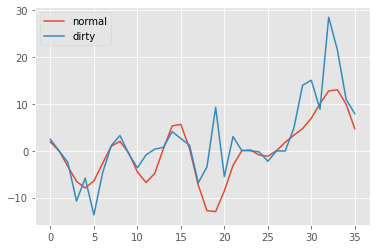

In [10]:
plt.plot([i for i in range(X_train.shape[1])], X_train[0, :, 0], label='normal')
plt.plot([i for i in range(X_train.shape[1])], x(X_train[0, :, 0], training=True), label='dirty')
plt.legend()
plt.show()

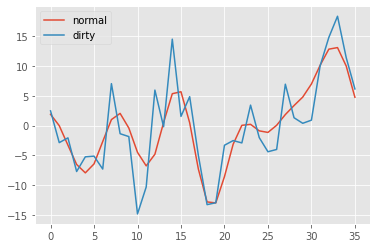

In [11]:
x = tfkl.GaussianNoise(4)

plt.plot([i for i in range(X_train.shape[1])], X_train[0, :, 0], label='normal')
plt.plot([i for i in range(X_train.shape[1])], x(X_train[0, :, 0], training=True), label='dirty')
plt.legend()
plt.show()

In [12]:
epochs = 300
batch_size = 512
lr = 1e-3

e_s = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    restore_best_weights=True,
    patience=40
)

r_LR = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=15,
    mode='max',
    verbose=1,
    min_lr=1e-5
)


callbacks = [e_s, r_LR]

In [26]:
def build_model(input_shape, n_classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Feature extractor
    convs = []
    
    for _ in range(input_shape[-1]):
        x = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
        x = tfkl.MaxPooling1D()(x)
        x = tfkl.Conv1D(128,3,padding='same',activation='relu')(x)
        convs.append(x)
        
    x = tfkl.Concatenate()(convs)
    x = tfkl.GlobalAveragePooling1D()(x)
    x = tfkl.Dropout(.2, seed=seed)(x)
    
    
    x = tfkl.Dense(128, activation='relu')(x)
    # Classifier
    output_layer = tfkl.Dense(n_classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    # Return the model
    return model

In [27]:
model = build_model(X_train.shape[1:], 12)

categorical_loss = tfk.losses.CategoricalCrossentropy()

model.compile(loss=categorical_loss, optimizer=tfk.optimizers.Adam(learning_rate=lr), metrics='accuracy')

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, y_val),
    shuffle=True,
    class_weight=w_s,
    workers=4,
    use_multiprocessing=True,
)

Epoch 1/300
145/145 [==============================] - 4s 23ms/step - loss: 2.3878 - accuracy: 0.2428 - val_loss: 2.3848 - val_accuracy: 0.3338
Epoch 2/300
145/145 [==============================] - 3s 20ms/step - loss: 1.5169 - accuracy: 0.3756 - val_loss: 2.1455 - val_accuracy: 0.3698
Epoch 3/300
145/145 [==============================] - 3s 20ms/step - loss: 1.2048 - accuracy: 0.4469 - val_loss: 1.7513 - val_accuracy: 0.4145
Epoch 4/300
145/145 [==============================] - 3s 20ms/step - loss: 1.0852 - accuracy: 0.4748 - val_loss: 2.1509 - val_accuracy: 0.4426
Epoch 5/300
145/145 [==============================] - 3s 20ms/step - loss: 0.9821 - accuracy: 0.5060 - val_loss: 1.8944 - val_accuracy: 0.5058
Epoch 6/300
145/145 [==============================] - 3s 21ms/step - loss: 0.8735 - accuracy: 0.5423 - val_loss: 1.9665 - val_accuracy: 0.5002
Epoch 7/300
145/145 [==============================] - 3s 20ms/step - loss: 1.0404 - accuracy: 0.5218 - val_loss: 1.8902 - val_accuracy:

0.7429114580154419
0.9954979419708252


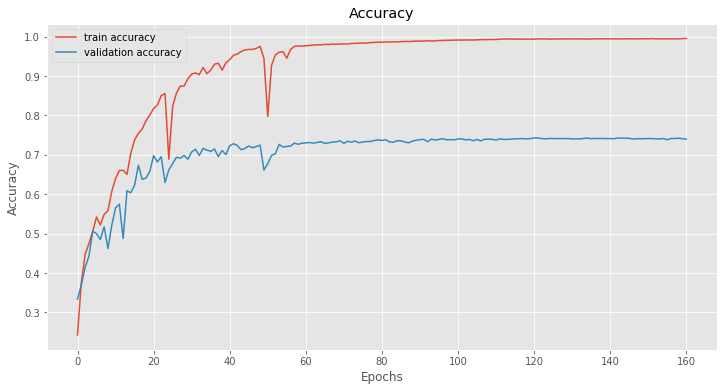

In [28]:
print(np.max(history.history['val_accuracy']))
print(np.max(history.history['accuracy']))
x_axis = np.arange(len(history.history['val_accuracy']))

plt.figure(figsize=(12, 6))
plt.title("Accuracy")
plt.plot(x_axis, history.history["accuracy"], label="train accuracy")
plt.plot(x_axis, history.history["val_accuracy"], label="validation accuracy")


plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [30]:
c_m, report = evaluate_model(model, X_val, y_val)

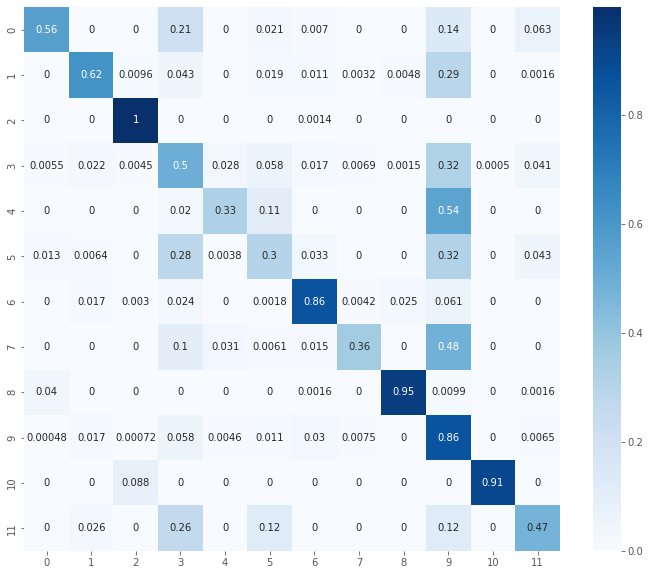

In [31]:
plt.figure(figsize=(12, 10))
sns.heatmap(c_m, cmap='Blues', annot=True)
plt.show()

In [32]:
report

,0,1,2,3,4,5,6,7,8,9,10,11
precision,0.629921,0.714286,0.961931,0.603853,0.518919,0.492723,0.877388,0.686047,0.922953,0.699766,0.997085,0.418868
recall,0.559441,0.617978,0.998589,0.497273,0.326531,0.301911,0.863554,0.361963,0.947282,0.864982,0.912000,0.472340
f1-score,0.592593,0.662651,0.979917,0.545405,0.400835,0.374408,0.870416,0.473896,0.934959,0.773652,0.952646,0.444000
support,143.000000,623.000000,1417.000000,2017.000000,294.000000,785.000000,1649.000000,326.000000,607.000000,4155.000000,375.000000,235.000000


In [33]:
model.save('models/')